In [1]:
# Importation des modules necessaires
import sys
sys.path.insert(0,'../')
import argopy
import xarray as xr
import glob
import numpy as np
from m_argo_data import *
from m_WOA_data import *
from m_NCEP_data import *

from m_fonctions import *
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seawater as sw

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_3226/2067290737.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
#
# Init.
#
num_float = '6902802'

# Infos pour correction WOA
rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'
which_var = 2
min_pres_interp = 0
max_pres_interp = 100

pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# Infos pour correction NCEP
rep_NCEP_data= '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/NCEP/'
ftp_server = 'ftp.cdc.noaa.gov'
rep_ftp = 'Datasets/ncep.reanalysis/surface'
rep_local = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
ncep_variables = ['slp','air.sig995','rhum.sig995']
code_inair = [699,711,799]
code_inwater = [690,710]
min_pres = 0
max_pres = 10

In [3]:
launch_date = read_argo_launch_date(num_float,rep_data_argo)
dsargo = read_argo_data_for_WOA(num_float,rep_data_argo,which_var,temp_qc,sal_qc,doxy_qc)
#print(launch_date)
#dsargo

In [4]:
delta_T_WOA = (dsargo['JULD'].values - launch_date)
delta_T_WOA = delta_T_WOA.astype(float)
delta_T_WOA = delta_T_WOA/1e9/86400 # Difference en jour

In [5]:
dswoa = read_WOA(fic_WOA,dsargo['LONGITUDE'],dsargo['LATITUDE'],dsargo['JULD'])
#dswoa

Extrapolation WOA temporelle en cours pour la variable : doxywoa
Extrapolation WOA temporelle en cours pour la variable : Psatwoa
Extrapolation WOA temporelle en cours pour la variable : density
Extrapolation WOA temporelle en cours pour la variable : preswoa
Extrapolation WOA temporelle en cours pour la variable : PSAL_WOA
Extrapolation WOA temporelle en cours pour la variable : TEMP_WOA


In [6]:
# Interpolation WOA et ARGO ur une grille reguliere en pression.
var_to_interpol = [var for var in dswoa.data_vars if "Depth" in dswoa[var].dims]
nb_profil = len(dswoa['N_PROF'])
woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,nb_profil,var_to_interpol,dswoa,'preswoa')

var_to_interpol = [var for var in dsargo.data_vars if "N_LEVELS" in dsargo[var].dims]
nb_profil = len(dsargo['N_PROF'])
argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,nb_profil,var_to_interpol,dsargo,'PRES_ARGO')

Interpolation de la variable doxywoa sur grille reguliere en pression
Interpolation de la variable Psatwoa sur grille reguliere en pression
Interpolation de la variable density sur grille reguliere en pression
Interpolation de la variable preswoa sur grille reguliere en pression
Interpolation de la variable PSAL_WOA sur grille reguliere en pression
Interpolation de la variable TEMP_WOA sur grille reguliere en pression
Interpolation de la variable TEMP_ARGO sur grille reguliere en pression
Interpolation de la variable TEMP_ARGO_QC sur grille reguliere en pression
Interpolation de la variable PSAL_ARGO sur grille reguliere en pression
Interpolation de la variable PSAL_ARGO_QC sur grille reguliere en pression
Interpolation de la variable DOXY_ARGO sur grille reguliere en pression
Interpolation de la variable DOXY_ARGO_QC sur grille reguliere en pression
Interpolation de la variable PRES_ARGO sur grille reguliere en pression
Interpolation de la variable PRES_ARGO_QC sur grille reguliere en

In [7]:
# Calcul de PPOX WOA.
ppox_WOA = O2stoO2p(woa_interp['Psatwoa'],argo_interp['TEMP_ARGO'],argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

In [8]:
ana_dens = sw.pden(argo_interp['PSAL_ARGO'],argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(argo_interp['DOXY_ARGO'],dsargo['DOXY_ARGO'].units,ana_dens)

In [9]:
ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,argo_interp['TEMP_ARGO'],argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [10]:
print(dsargo['CYCLE_NUMBER'].values)
print(ppox_ARGO_mean)
print(ppox_WOA_mean)

[  1   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158]
[         nan 201.81524196 196.11543587 195.67828501 195.89142376
 195.01301291 192.53920072 192.77054336 193.58400232 190.49174451
 191.39100445 194.21756401 192.95418753 193.76925732 192.75772793
 194.40165788 193.37089703 192.64975801 193.24897233 192.73735872
 192.05329559 191.03281119 189.64388292 190.30123956 190.00913989
 189.49343105 191.104453

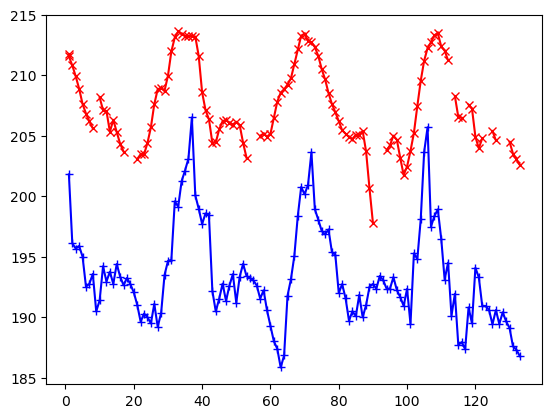

In [11]:
plt.figure()
plt.plot(dsargo['CYCLE_NUMBER'],ppox_ARGO_mean,'+b-')
plt.plot(dsargo['CYCLE_NUMBER'],ppox_WOA_mean,'xr-')

In [12]:
# Ajustement de G via WOA
initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean, ppox_WOA_mean, p0=initial_guess,nan_policy='omit')
print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)

initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')
print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)


[1.06982001]
[1.07029539]


In [13]:
# Ajustement des paramètres G et D via WOA
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive_WOA)

initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive_WOA)

[1.06725039 0.13742325]
[1.06763876 0.14138748]


In [14]:
# Correction via NCEP
dsair,dsinwater,optode_height = read_argo_data_for_NCEP(num_float,rep_data_argo,which_var,code_inair,code_inwater,min_pres,max_pres)
#download_NCEP(dsair['JULD'],ftp_server,rep_ftp,rep_local,ncep_variables)
ds_NCEP_air,ds_NCEP_slp,ds_NCEP_rhum = read_NCEP(rep_NCEP_data,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_slp,ds_NCEP_rhum,optode_height,z0q)

Recherche de la valeur de PSAL dans Sprof correcte la plus proche de la surface entre 0 et 10
Recherche de la valeur de PSAL_ADJUSTED dans Sprof correcte la plus proche de la surface entre 0 et 10
On conserve les donnees PSAL_ADJUSTED


In [15]:
delta_T_NCEP = (dsair['JULD'].values - launch_date)
delta_T_NCEP = delta_T_NCEP.astype(float)
delta_T_NCEP = delta_T_NCEP/1e9/86400 # Difference en jour

In [16]:
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
initial_guess = 1
params_Gain_NCEP, covariance = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit')

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [17]:
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [18]:
print(params_Gain_WOA)
print(params_Gain_NCEP)
print(params_Gain_NCEP_CarryOver[0])
print(params_Gain_Derive_WOA)
print(params_Gain_Derive_NCEP)
print(params_Gain_Derive_NCEP_CarryOver[0],params_Gain_Derive_NCEP_CarryOver[2])

[1.07029539]
[1.06011597]
1.0597738241980104
[1.06763876 0.14138748]
[1.05070607 0.4618105 ]
1.0505692439231553 0.45382920462296367


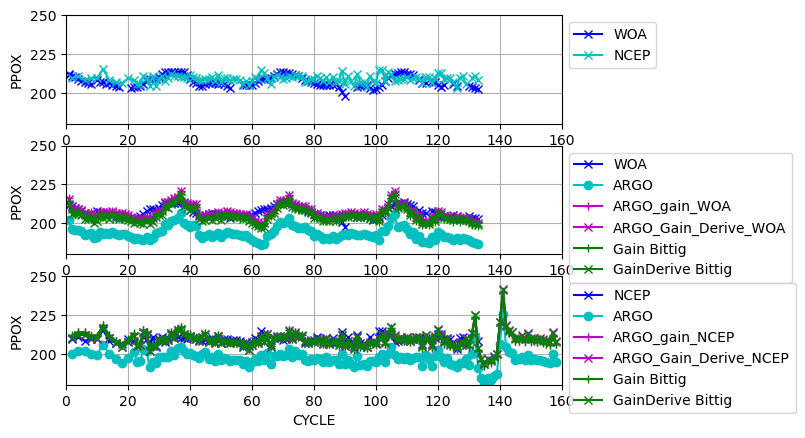

In [44]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(dsargo['CYCLE_NUMBER'],ppox_WOA_mean,'x-b')
plt.plot(dsair['CYCLE_NUMBER'],NCEP_PPOX,'x-c')
plt.ylim([180,250])
plt.xlim([0,160])
plt.grid()
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.legend(['WOA','NCEP'],loc='upper left',bbox_to_anchor=(1,1))

plt.subplot(3,1,2)
plt.plot(dsargo['CYCLE_NUMBER'],ppox_WOA_mean,'x-b')
plt.plot(dsargo['CYCLE_NUMBER'],ppox_ARGO_mean,'o-c')
plt.plot(dsargo['CYCLE_NUMBER'],model_Gain(ppox_ARGO_mean,*params_Gain_WOA),'+m-')
plt.plot(dsargo['CYCLE_NUMBER'],model_Gain_Derive([ppox_ARGO_mean,delta_T_WOA],*params_Gain_Derive_WOA),'xm-')
plt.plot(dsargo['CYCLE_NUMBER'],ppox_ARGO_mean* 1.0605,'+g-')
plt.plot(dsargo['CYCLE_NUMBER'],ppox_ARGO_mean* (1.0513 * (1+delta_T_WOA/365*0.389/100)),'xg-')
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.grid()
plt.ylim([180,250])
plt.xlim([0,160])
plt.legend(['WOA','ARGO','ARGO_gain_WOA','ARGO_Gain_Derive_WOA','Gain Bittig','GainDerive Bittig'],loc='upper left',bbox_to_anchor=(1,1))
plt.subplot(3,1,3)
plt.plot(dsair['CYCLE_NUMBER'],NCEP_PPOX,'x-b')
plt.plot(dsair['CYCLE_NUMBER'],PPOX1,'o-c')
plt.plot(dsair['CYCLE_NUMBER'],model_Gain(PPOX1,*params_Gain_NCEP),'+m-')
plt.plot(dsair['CYCLE_NUMBER'],model_Gain_Derive([PPOX1,delta_T_NCEP],*params_Gain_Derive_NCEP),'xm-')
plt.plot(dsair['CYCLE_NUMBER'],PPOX1* 1.0605,'+g-')
plt.plot(dsair['CYCLE_NUMBER'],PPOX1* (1.0513 * (1+delta_T_NCEP/365*0.389/100)),'xg-')
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.grid()
plt.ylim([180,250])
plt.xlim([0,160])
plt.legend(['NCEP','ARGO','ARGO_gain_NCEP','ARGO_Gain_Derive_NCEP','Gain Bittig','GainDerive Bittig'],loc='upper left',bbox_to_anchor=(1,1))




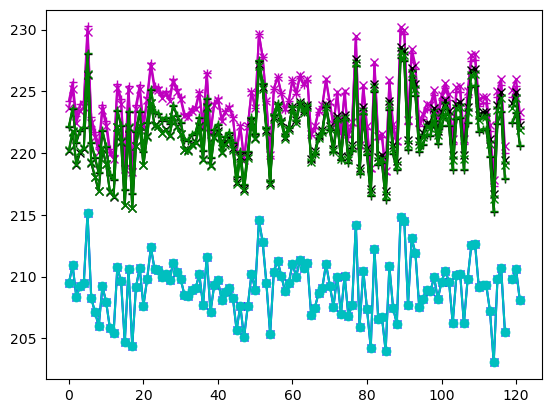

In [44]:
plt.figure()
plt.plot(NCEP_PPOX,'x-b')
plt.plot(NCEP_PPOX,'o-c')
plt.plot(model_Gain(NCEP_PPOX,*params_Gain_WOA),'+m-')
plt.plot(model_Gain_Derive([NCEP_PPOX,delta_T_NCEP],*params_Gain_Derive_WOA),'xm-')
plt.plot(model_Gain(NCEP_PPOX,*params_Gain_NCEP),'+k-')
plt.plot(model_Gain_Derive([NCEP_PPOX,delta_T_NCEP],*params_Gain_Derive_NCEP),'xk-')
plt.plot(NCEP_PPOX* 1.0605,'+g-')
plt.plot(NCEP_PPOX* (1.0513 * (1+delta_T_NCEP/365*0.389/100)),'xg-')

In [36]:
# Correction PPOX
ppox_ARGO_corr = model_Gain(ppox_ARGO,*params_Gain_WOA)
O2_corr = O2ptoO2c(ppox_ARGO_corr,argo_interp['TEMP_ARGO'],argo_interp['PSAL_ARGO']) # en micromole/L.

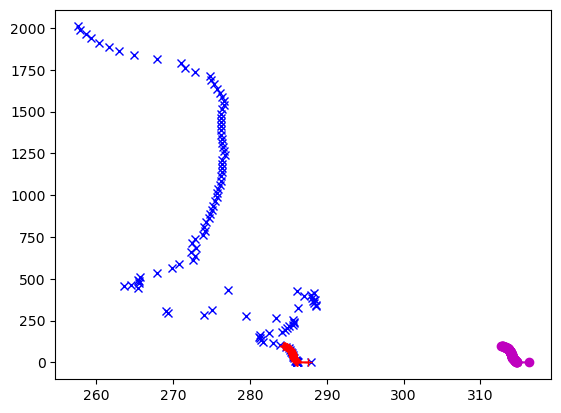

In [37]:
plt.figure()
plt.plot(dsargo['DOXY_ARGO'][21,:],dsargo['PRES_ARGO'][21,:],'xb-')
plt.plot(argo_interp['DOXY_ARGO'][21,:],np.arange(min_pres_interp,max_pres_interp+1,1),'+r-')
plt.plot(O2_corr[21,:],np.arange(min_pres_interp,max_pres_interp+1,1),'om-')

In [39]:
O2_corr.shape

(159, 101)

In [40]:
#ana_dens = sw.pden(argo_interp['PSAL_ARGO'],argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
#O2_ARGO_umolL = umolkg_to_umolL(argo_interp['DOXY_ARGO'],dsargo['DOXY_ARGO'].units,ana_dens)
psat_argo = O2ctoO2s(O2_corr,argo_interp['TEMP_ARGO'],argo_interp['PSAL_ARGO'])#,np.arange(min_pres_interp,max_pres_interp+1,1))

In [41]:
new_pres = np.arange(min_pres_interp,max_pres_interp+1,1).reshape(1,max_pres_interp+1-min_pres_interp)
print(new_pres.shape)
new_pres = np.tile(new_pres.transpose(),psat_argo.shape[0]).transpose()
print(new_pres.shape)

(1, 101)
(159, 101)


(159, 101)
(159, 101)


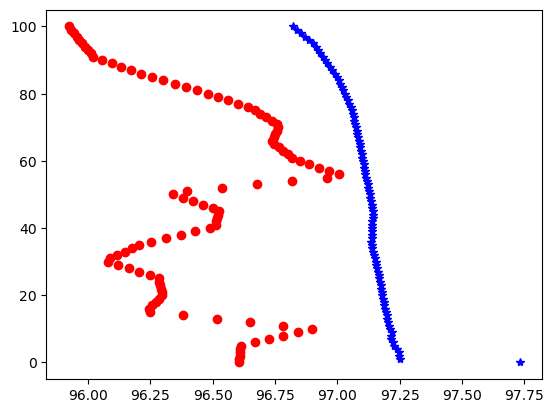

In [42]:
print(woa_interp['Psatwoa'].shape)
print(psat_argo.shape)
plt.figure()
plt.plot(woa_interp['Psatwoa'][21,:],new_pres[21,:],'or')
plt.plot(psat_argo[21,:],new_pres[21,:],'*b')


In [11]:
# Calcul Gain avec CarryOver
def model_Gain_CarryOver(X,G,C):
    return G * (X[0] - C * X[1]) / (1 - C) # C : Carry-over

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
print(params_Gain_CarryOver)
#params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='trf')
#print(params_Gain_CarryOver)
#params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain_CarryOver)

Gain_CarryOver,C_estime = params_Gain_CarryOver

[1.06168545 0.09066918]


In [12]:
def model_Gain_Derive(X,G,D):
    return (G * (1 + (D * X[1])/(365*100)) * X[0] )

# Ajustement des paramètres G et D
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1,delta_T], NCEP_PPOX, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive)
print(np.sqrt(np.diag(covariance)))
Gain_Derive, Derive = params_Gain_Derive

[1.0505639  0.50892684]
[0.0043184  0.17478419]


In [13]:
def model_Gain_Derive_CarryOver(X,G,C,D):
    return (G / (1-C) * (1 + D / 100 * X[2]/365) * (X[0] - C * X[1]) )

# Ajustement des paramètres G et D
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

Gain_Derive_CarryOver, C_estime, Derive_CarryOver = params_Gain_Derive_CarryOver
print(Gain_Derive,Derive)
print(Gain_Derive_CarryOver,Derive_CarryOver)

1.0505639024882532 0.5089268375093455
1.0491167424077168 0.5904557336542134


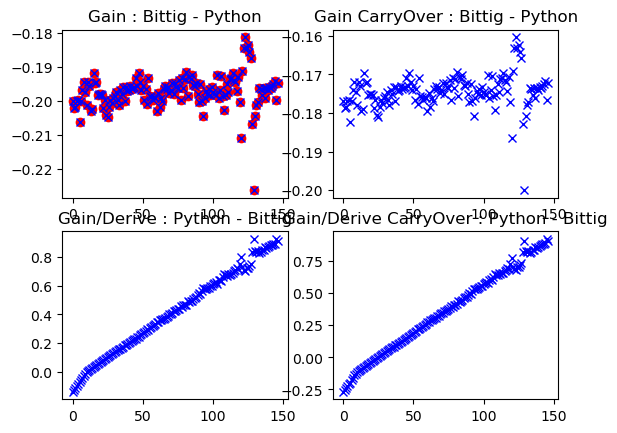

In [14]:
Gain_Derive_bittig = 1.0513
Derive_bittig = 0.389
Gain_Derive_bittig_CarryOver = 1.0505
Derive_bittig_CarryOver = 0.456
Gain_bittig = 1.0605
Gain_bittig_CarryOver = 1.0608

plt.figure()
plt.subplot(2,2,1)
plt.plot(Gain_bittig *  PPOX1 - Gain * PPOX1,'or')
plt.plot(Gain_bittig *  PPOX1 - model_Gain(PPOX1,*params_Gain),'xb')
plt.title('Gain : Bittig - Python')
plt.subplot(2,2,2)
#plt.plot(Gain_bittig_CarryOver *  PPOX1 - model_Gain_CarryOver([PPOX1,PPOX2],*params_Gain_CarryOver),'or')
plt.plot(Gain_bittig_CarryOver *  PPOX1 - Gain_CarryOver * PPOX1,'xb')

plt.title('Gain CarryOver : Bittig - Python')
plt.subplot(2,2,3)
plt.plot(Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig * (1 + Derive_bittig / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive : Python - Bittig')
plt.subplot(2,2,4)
plt.plot(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig_CarryOver * (1 + Derive_bittig_CarryOver / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive CarryOver : Python - Bittig')
plt.show()

In [15]:
# Calcul de la derive comme Locodox
#
valid_index = np.isfinite(NCEP_PPOX)
PPOX1 = PPOX1[valid_index]
PPOX2 = PPOX2[valid_index]
delta_T = delta_T[valid_index]
NCEP_PPOX = NCEP_PPOX[valid_index]
degre_poly = 1
Derive_Locodox1 = np.polyfit(delta_T,NCEP_PPOX/PPOX1,degre_poly)

def model_test(X,A,B):
    return (A*X +B) 
    
def model_test2(X,A,B):
    return (A*X[1] +B) * X[0]

# Ajustement des paramètres G et D
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
NCEP_PPOX_UN = NCEP_PPOX.copy()
NCEP_PPOX_UN[:] = 1
params_test, covariance,info,mesg,ier = curve_fit(model_test2, [PPOX1,delta_T], NCEP_PPOX, p0=initial_guess,nan_policy='omit',full_output=True)
params_test2, covariance,info,mesg,ier = curve_fit(model_test2, [PPOX1/NCEP_PPOX,delta_T], NCEP_PPOX_UN, p0=initial_guess,nan_policy='omit',full_output=True)
params_test3, covariance,info,mesg,ier = curve_fit(model_test, delta_T, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)

print(Derive_Locodox1)
print(params_test)
print(params_test2)
print(params_test3)

[1.72152658e-05 1.04967266e+00]
[1.46482144e-05 1.05056391e+00]
[1.46610129e-05 1.05056503e+00]
[1.72152623e-05 1.04967266e+00]


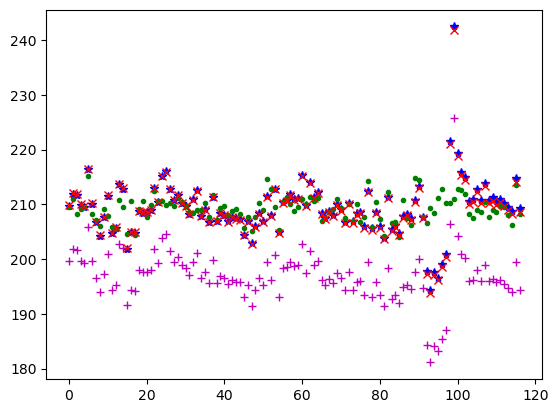

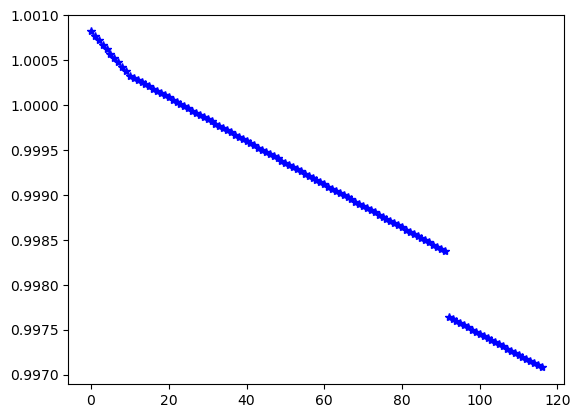

[1.72152658e-05 1.04967266e+00]


In [16]:
plt.figure()
plt.plot(np.polyval(Derive_Locodox1,delta_T)*PPOX1,'*b')
plt.plot(PPOX1,'+m')
plt.plot(NCEP_PPOX,'.g')
#plt.plot((Derive_Locodox1[0]*delta_T+Derive_Locodox1[1])*PPOX1,'xr')
plt.plot(Gain_Derive * (1 + (Derive * delta_T)/(365*100)) * PPOX1, 'xr')
plt.figure()
plt.plot(Gain_Derive * (1 + (Derive * delta_T)/(365*100)) * PPOX1 / (np.polyval(Derive_Locodox1,delta_T)*PPOX1),'*b')
plt.show()
print(Derive_Locodox1)

In [17]:
# Sans CarryOver TEST
def model_Gain_Derive_Locodox(X,G):
    return X * G

initial_guess = 1
params_Locodox, covariance = curve_fit(model_Gain_Derive_Locodox,(params_test[0]*delta_T+params_test[1])*PPOX1 , NCEP_PPOX, p0=initial_guess)
Gain_Locodox1 = params_Locodox
print(params_Locodox)
#print(np.sqrt(np.diag(covariance)))

# On en deduit D associe a la formule G * (1 + D / 100 * delta_T/365) * PPOX1 
def model_Locodox(X, G, D):
    return (G * (1 + (D * X[1])/(365*100)) * X[0] )
#    return  G * (1 + D / 100 * X[1]/365)  * X[0] # Sans carry-over

initial_guess = [1, 0]  # Valeurs initiales pour G et D
params_Locodox, covariance = curve_fit(model_Locodox, [PPOX1,delta_T], Gain_Locodox1*(params_test[0]*delta_T+params_test[1])*PPOX1, p0=initial_guess)


#params_Locodox, covariance = curve_fit(model_Locodox, [PPOX1,delta_T], np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)
print(params_Locodox)
#print(np.sqrt(np.diag(covariance)))
#Gain_Locodox, Derive_Locodox = params_Locodox
Gain_Locodox = Gain_Locodox1 * params_test[1]
Derive_Locodox = params_test[0]*100*365/params_test[1]
print(Gain_Locodox,Derive_Locodox)
print(Gain_Derive,Derive)


[1.]
[1.05056391 0.50892651]
[1.05056391] 0.5089265116495119
1.0505639024882532 0.5089268375093455


In [32]:
def model_Gain_Derive(X,G,D):
    return (G * (1 + (D * X)/(365*100)) )

# Ajustement des paramètres G et D
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, delta_T, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive)
#print(np.sqrt(np.diag(covariance)))
Gain_Derive2, Derive2 = params_Gain_Derive

# Sans CarryOver Test2
def model_Gain_Derive_Locodox(X,G):
    return X * G

initial_guess = 1
params_Locodox, covariance = curve_fit(model_Gain_Derive_Locodox, np.polyval(Derive_Locodox1,delta_T), NCEP_PPOX/PPOX1, p0=initial_guess)
Gain_Locodox1 = params_Locodox
print(params_Locodox)
#print(np.sqrt(np.diag(covariance)))

# On en deduit D associe a la formule G * (1 + D / 100 * delta_T/365) * PPOX1 
def model_Locodox(X, G, D):
    return (G * (1 + (D * X)/(365*100)))
#    return  G * (1 + D / 100 * X[1]/365)  * X[0] # Sans carry-over

initial_guess = [1, 0]  # Valeurs initiales pour G et D
params_Locodox, covariance = curve_fit(model_Locodox, delta_T, Gain_Locodox1*np.polyval(Derive_Locodox1,delta_T), p0=initial_guess)


#params_Locodox, covariance = curve_fit(model_Locodox, [PPOX1,delta_T], np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)
print(params_Locodox)
#print(np.sqrt(np.diag(covariance)))
#Gain_Locodox, Derive_Locodox = params_Locodox
Gain_Locodox2 = Gain_Locodox1 * Derive_Locodox1[1]
Derive_Locodox2 = Derive_Locodox1[0]*100*365/Derive_Locodox1[1]
print(Gain_Locodox2,Derive_Locodox2)
print(Gain_Derive2,Derive2)

[1.04967266 0.59862202]
[1.]
[1.04967266 0.59862205]
[1.04967266] 0.5986220548359624
1.049672657475801 0.5986220157046681


In [31]:
print(type(NCEP_PPOX))
bid = NCEP_PPOX.copy()
bid[:]=1
bid2=bid
print(bid2[0:10],bid[0:10])
bid2[:]=22
print(bid2[0:10],bid[0:10])
bid[:]=33
print(bid2[0:10],bid[0:10])


<class 'numpy.ndarray'>
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[22. 22. 22. 22. 22. 22. 22. 22. 22. 22.] [22. 22. 22. 22. 22. 22. 22. 22. 22. 22.]
[33. 33. 33. 33. 33. 33. 33. 33. 33. 33.] [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]


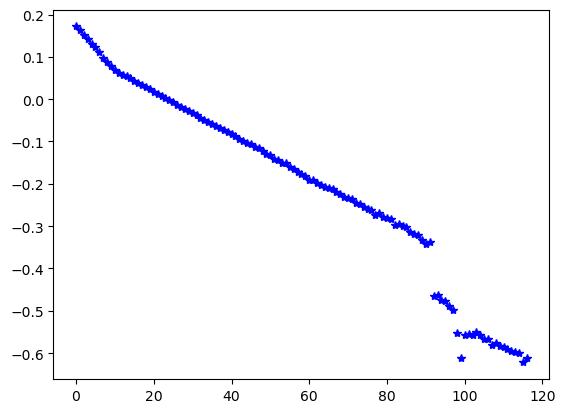

In [23]:
plt.figure()
plt.plot((1.05056391 * (1 + ( 0.5089265116495119 * delta_T)/(365*100))*PPOX1) -  (1.04967266 * (1 + ( 0.59862205 * delta_T)/(365*100))*PPOX1),'*b')


In [20]:
# Avec CarryOver
PPOX2 = np.polyval(Derive_Locodox1,delta_T)*PPOX2 # Application de la derive sur PPOX2
def model_Gain_Derive_Locodox_CarryOver(X,G,C):
    return G / (1-C) * (X - C * PPOX2) # C : Carry-over

initial_guess = [1,0]
params_Locodox, covariance = curve_fit(model_Gain_Derive_Locodox_CarryOver, np.polyval(Derive_Locodox1,delta_T)*PPOX1, NCEP_PPOX, p0=initial_guess)
Gain_Locodox_CarryOver1, C_estime = params_Locodox

def model_Locodox2(X,G,D,C):
    return (G/(1-C) * (1 + D / 100 * X[2]/365) * (X[0] - C * X[1]) )

#def model_Locodox3(X,G,D,C):
#    return (G/(1-C) * (1 + D / 100 * delta_T/365) * (X - C * PPOX2) )
    
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D
params_Locodox_CarryOver, covariance = curve_fit(model_Locodox2, [PPOX1,PPOX2,delta_T], Gain_Locodox_CarryOver1*np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)  
#params_Locodox_CarryOver, covariance = curve_fit(model_Locodox3, Gain_Locodox_CarryOver1*np.polyval(Derive_LOCODOX1,delta_T)*PPOX1, Gain_Locodox_CarryOver1*np.polyval(Derive_LOCODOX1,delta_T)*PPOX1,p0=initial_guess)  
print(params_Locodox_CarryOver)

Gain_Locodox_CarryOver = Gain_Locodox_CarryOver1 * Derive_Locodox1[1]
Derive_Locodox_CarryOver = Derive_Locodox1[0]*100*365/Derive_Locodox1[1]

print(Gain_Locodox,Derive_Locodox)
print(Gain_Derive,Derive)
print(Gain_Locodox_CarryOver,Derive_Locodox_CarryOver)
print(Gain_Derive_CarryOver,Derive_CarryOver)

[1.04894435e+00 5.98622057e-01 2.10336216e-09]
[1.04967266] 0.5986220548359624
1.049672657475801 0.5986220157046681
1.048944352683347 0.5986220548359624
1.0491167424077168 0.5904557336542134


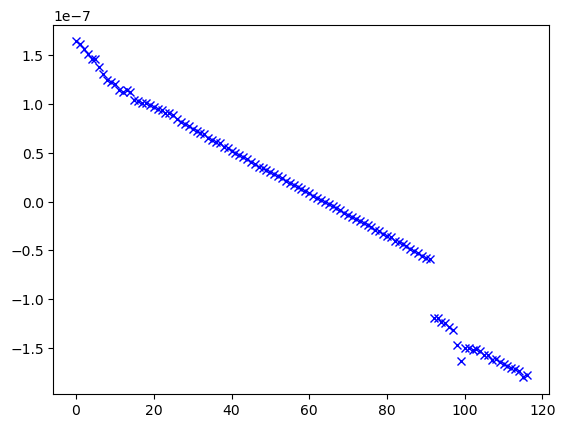

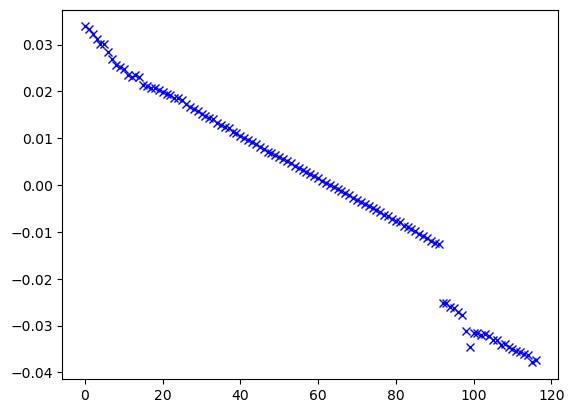

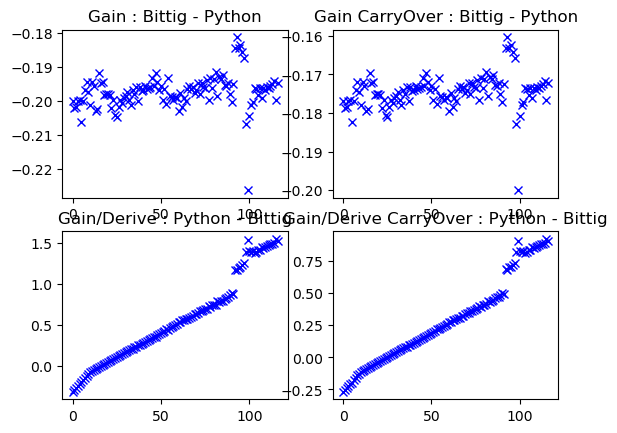

201.78134155273438
211.91597420851323
212.2053685480709
211.80221995388592
212.05639065268062


In [21]:
Gain_Derive_bittig = 1.0513
Derive_bittig = 0.389
Gain_Derive_bittig_CarryOver = 1.0505
Derive_bittig_CarryOver = 0.456
Gain_bittig = 1.0605
Gain_bittig_CarryOver = 1.0608
plt.figure()
plt.plot(Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1 - Gain_Locodox * (1 + Derive_Locodox / 100 * delta_T/365) * PPOX1,'xb')
plt.figure()
plt.plot(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T/365) * PPOX1 - Gain_Locodox_CarryOver * (1 + Derive_Locodox_CarryOver / 100 * delta_T/365) * PPOX1,'xb')

plt.figure()
plt.subplot(2,2,1)
plt.plot(Gain_bittig *  PPOX1 - Gain * PPOX1,'xb')
plt.title('Gain : Bittig - Python')
plt.subplot(2,2,2)
plt.plot(Gain_bittig_CarryOver *  PPOX1 - Gain_CarryOver * PPOX1,'xb')
plt.title('Gain CarryOver : Bittig - Python')
plt.subplot(2,2,3)
plt.plot(Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig * (1 + Derive_bittig / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive : Python - Bittig')
plt.subplot(2,2,4)
plt.plot(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig_CarryOver * (1 + Derive_bittig_CarryOver / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive CarryOver : Python - Bittig')
plt.show()

